
####Ceren Guzel Turhan - 2265445

# Part 1: Implementation of a modular back-propagation network

## MyNN.py 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def fc(X, params):
    # Fully-connected layer
    #
    # Inputs:
    #   X: N-by-D dimensional numpy array. N: number of examples, D: number of
    #       features.
    #   params: a list containing two items: W and b which are explained below.
    #   W: D-by-K dimensional numpy array storing the weights of the fully
    #       connected layer. D is the dimensionality of the input layer, and K
    #       is the number of neurons in the output layer.
    #   b: 1-by-K dimensional numpy array storing the bias terms.
    #
    # Outputs:
    #   This function must return a Python dictionary with the following fields:
    #       out, dx, dw and db. 
    #   out: Output of the fully connected layer, which is N-by-K numpy array.
    #   dx: Derivative of the output w.r.t. the input. D-by-K dimensional.
    #   dw: Derivative of the output w.r.t. the weights. N-by-D dimensional.
    #   db: Derivative of the output w.r.t. the biases. N-by-1 dimensional.

    W,b = params
    out = np.dot(X, W) + b
    dx = W
    dw = X
    db = 1

    return {'out':out, 'dx':dx, 'dw':dw, 'db':db}



def relu(X, ignored):
    # Rectified linear unit layer. 
    #
    # This layer receives two inputs. The second input is ignored. The first
    # input, X, is a M-by-N array. 
    #
    # Output is a Python dictionary with fields out and dx. 
    # out: Output of ReLU. M-by-N dimensional. 
    # dx: Derivative of the output w.r.t. the input. 
    out = np.maximum(0,X) 
    
    dx = 1.0 * (X > 0)

    #dx = 1.0 if X > 0 else 0.0 



    return {'out':out, 'dx':dx}

def softmax_cross_entropy(X, Y):
    # Softmax + cross-entropy layer. This layer is used when training the
    # network. 
    #
    # This layer receives two inputs: X and Y. 
    # X: classification scores output by the model. N-by-K array. N is the
    #   number of examples. K is the number of classes. 
    # Y: ground-truth labels, i.e. class indices, for the examples. N-by-1
    #   array.
    #
    # Output is a Python dictionary with fields out and dx. 
    # out: Output of cross-entropy. A scalar. 
    # dx: Derivative of the output w.r.t. the input. 

    # This implementation is given for you. 


    # Softmax
    e_x = np.exp(X - np.max(X, axis=1, keepdims=True))
    probs = e_x / np.sum(e_x,axis=1, keepdims=True)
    N = X.shape[0]
    # compute loss
    out = -np.sum(np.log(probs[np.arange(N), Y])) / N
    dx = probs.copy()
    dx[np.arange(N), Y] = dx[np.arange(N), Y] - 1 ## dE/dx
    dx = dx/N
    return {'out':out, 'dx':dx}

def softmax_readout(X, ignored):
    # Softmax layer (without cross-entropy). This layer is used when
    # evaluating/testing the trained network. 
    #
    # This layer receives two inputs. The second argument is ignored. 
    # X: classification scores output by the model. N-by-K array. N is the
    #   number of examples. K is the number of classes. 
    #
    # Output is a Python dictionary with fields out and dx. 
    # out: Output of softmax. N-by-K array.
    # dx: Derivative of the output w.r.t. the input. 

    # This implementation is given for you. 

    e_x = np.exp(X - np.max(X, axis=1, keepdims=True))
    probs = e_x / np.sum(e_x,axis=1, keepdims=True)
    return {'out':np.argmax(probs, axis=1)}


def evaluate(network, X):
    # Evaluates the given network on the given data X. Implements the forward
    # pass. 

    output_of_previous_layer = X

    for f in network:
        y = f[0](output_of_previous_layer, f[1])
        output_of_previous_layer = y['out']

    return y['out']



def train(network, X, Y, eta=.1, num_iters = 5000):
    # Trains the network on the given dataset. 
    # 
    # Inputs: 
    #   network: initial network. A network is a Python list. Each element of
    #       the list -- which is also a list --  specifies a layer in the
    #       network. Each layer is a two-element list. First element is the
    #       processing function of the layer, e.g. fc, relu, softmax, etc. By
    #       default, each layer takes the output of the previous layer as input.
    #       A layer can take an additional input which is specified in the
    #       second element of the list that defines the layer.
    #   X: N-by-D array. N is the number of examples, D: number of features. 
    #
    # Outputs are network and loss_vals. 
    #   network: The trained network. 
    #   loss_vals: Array of loss values over iterations.

    loss_vals = [];
    for iter in range(num_iters):
        output_of_previous_layer = X;

        # forward pass
        out_list = []
        for f in network:
            y = f[0](output_of_previous_layer, f[1])
            out_list.append(y)
            output_of_previous_layer = y['out']

        loss_vals.append(y['out'])

        # backward pass
        dout = out_list[-1]['dx'] # At each layer, dout is the derivative of the
                                  # training loss w.r.t. the input of that layer
        for i in range(len(network)-2,-1,-1):
            if network[i][0]==fc:
                # this is a FC layer, so we should update its parameters. FC
                # layer has two parameters W and b. W is at network[i][1][0] and
                # b is at network[i][1][1]. Write gradient descent update rules
                # for them. Use "eta" as the learning rate.
                grad_w = np.dot(out_list[i]['dw'].T, dout)
                grad_b = np.dot(dout.T, np.ones(len(dout)) * out_list[i]['db']) 
                network[i][1][0] = network[i][1][0] - eta * grad_w # W = W - eta*dw
                #tmp = network[i][1][1] - eta * grad_b
                network[i][1][1] = network[i][1][1] - eta * grad_b # b = b - eta*db

                # Propagate gradient by updating dout. dout is the derivative of
                # the loss w.r.t. FC's input. 
                dout = np.dot(dout,out_list[i]['dx'].T) # chain rule
            elif network[i][0]==relu:
                # RELU layer doesn't have any parameters, so nothing to update

                # propagate gradient
                dout = dout * out_list[i]['dx'] # chain rule
    return network, loss_vals

training accuracy: 0.49


/home/pc2/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


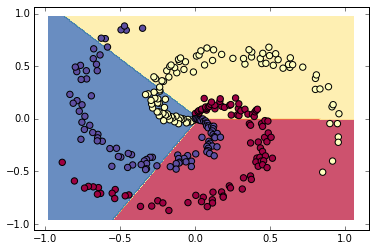

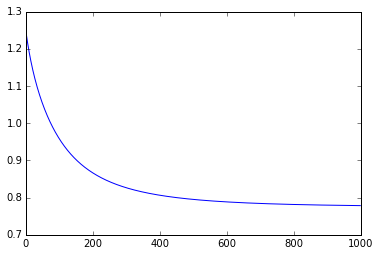

In [2]:
%run run_softmax.py data/spiral.npz

training accuracy: 0.86


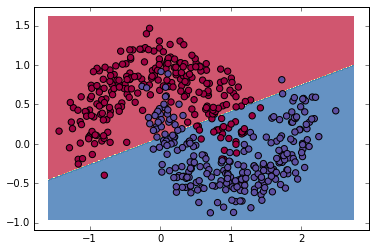

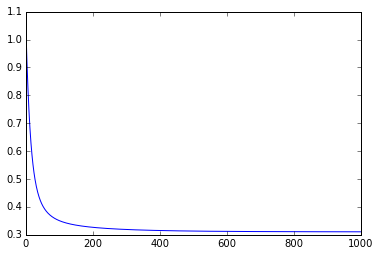

In [3]:
%run run_softmax.py data/moon.npz

training accuracy: 0.98


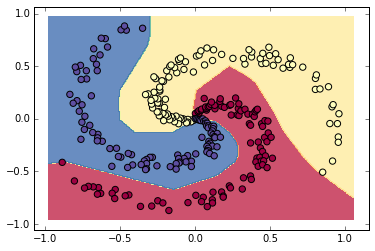

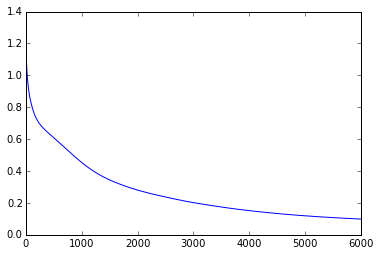

In [4]:
%run run_MLP.py data/spiral.npz

training accuracy: 0.96


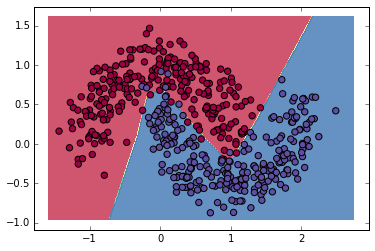

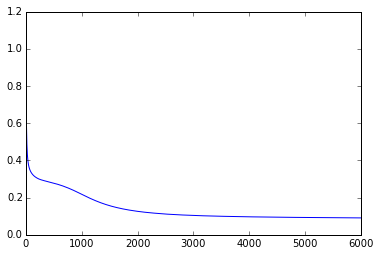

In [5]:
%run run_MLP.py data/moon.npz

# Part 2: Setting up and running a ConvNet using Tensorflow

## A2.1: convnet1.py

Iteration 640, Minibatch Loss= 416265728.000000, Training Accuracy= 0.14062
Iteration 1280, Minibatch Loss= 26936944.000000, Training Accuracy= 0.62500
Iteration 1920, Minibatch Loss= 2369852.500000, Training Accuracy= 0.92188
Iteration 2560, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 3200, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 3840, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 4480, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 5120, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 5760, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 6400, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 7040, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 7680, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 8320, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 8960, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 9600

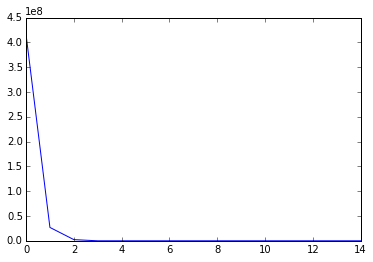

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 11 17:22:08 2016

@author: ceren
"""

import tensorflow as tf
import numpy as np
import zipfile
from matplotlib import pyplot as plt
%matplotlib inline 

# load dataset
zip_ref = zipfile.ZipFile("data/ORL_faces.npz.zip", 'r')
zip_ref.extractall("data/")
zip_ref.close()

data = np.load('data/ORL_faces.npz')

trainX = data['trainX']
testX = data['testX']
trainY = data['trainY']
testY = data['testY']

# parameters
n_class = np.unique(trainY).size
n_input = trainX.shape[1]
train_size = trainX.shape[0]
test_size = testX.shape[0]
M, N = 112, 92
batch_size = 64
display_step = 10
learning_rate = .01
iters = 10000

# convert labels to one-hot vectors
trainY = np.eye(n_class)[trainY]
testY = np.eye(n_class)[testY]

# tf inputs, variables
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_class])

weights = {
    # 7x7 conv, 1 input, 32 outputs
    'wconv1': tf.Variable(tf.random_normal([7, 7, 1, 32])),
    # 7x7 conv, 32 inputs, 64 outputs
    'wconv2': tf.Variable(tf.random_normal([7, 7, 32, 64])),
    # 7x7 conv, 64 inputs, 64 outputs
    'wconv3': tf.Variable(tf.random_normal([7, 7, 64, 64])),
    # fully connected, 28*23*64 inputs, 1024 outputs
    'wfc1': tf.Variable(tf.random_normal([28*23*64, 1024])),
    # 1024 inputs, 20 outputs   
    'out': tf.Variable(tf.random_normal([1024, n_class]))
}

biases = {
    'bconv1': tf.Variable(tf.random_normal([32])),
    'bconv2': tf.Variable(tf.random_normal([64])),
    'bconv3': tf.Variable(tf.random_normal([64])),
    'bfc1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_class]))
}

# conv2d function for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

# maxpool2d function for simplicity
def maxpool2d(x, k=2):
    # MaxPool2D 
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

# define CNN
def conv_net(x, weights, biases):
    
    # reshape input
    x = tf.reshape(x, shape=[-1, M, N, 1])

    # First Convolution Layer
    conv1 = conv2d(x, weights['wconv1'], biases['bconv1'])
    conv1 = maxpool2d(conv1, k=2)

    # Second Convolution Layer
    conv2 = conv2d(conv1, weights['wconv2'], biases['bconv2'])
    conv2 = maxpool2d(conv2, k=2)
    
    # Third Convolution Layer
    conv3 = conv2d(conv2, weights['wconv3'], biases['bconv3'])
    conv3 = maxpool2d(conv3, k=1)

    # Fully connected layer
    fc1 = tf.reshape(conv3, [-1, weights['wfc1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wfc1']), biases['bfc1'])
    fc1 = tf.nn.relu(fc1)

    # Class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out
    
def nextBatch():
    idx = np.random.choice(train_size,size=batch_size,replace=False)
    batch_x = trainX[idx, :]
    batch_y = trainY[idx, :]
    return batch_x, batch_y  
    
# construct model
pred = conv_net(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) 

# Initializing the variables
init = tf.initialize_all_variables()

losses = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step * batch_size < iters:
        batch_x, batch_y = nextBatch()
        
        # Run optimization 
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y} )
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
            print("Iteration " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            losses.append(loss)
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: testX, y: testY}))   
        
        
fig = plt.figure()
plt.plot(losses)
plt.show()
    

## A2.2: convnet2.py

Iteration 320, Minibatch Loss= 236367232.000000, Training Accuracy= 0.18750
Iteration 640, Minibatch Loss= 47145172.000000, Training Accuracy= 0.50000
Iteration 960, Minibatch Loss= 18209744.000000, Training Accuracy= 0.62500
Iteration 1280, Minibatch Loss= 7028228.000000, Training Accuracy= 0.75000
Iteration 1600, Minibatch Loss= 4535247.000000, Training Accuracy= 0.71875
Iteration 1920, Minibatch Loss= 858913.250000, Training Accuracy= 0.87500
Iteration 2240, Minibatch Loss= 69178.625000, Training Accuracy= 0.96875
Iteration 2560, Minibatch Loss= 165662.875000, Training Accuracy= 0.93750
Iteration 2880, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 3200, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 3520, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 3840, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 4160, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iteration 4480, Minibatch Loss= 0.000000, Training Accurac

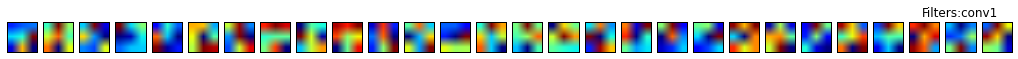

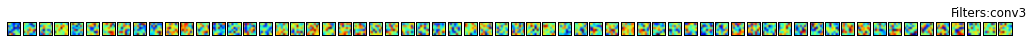

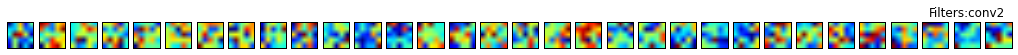

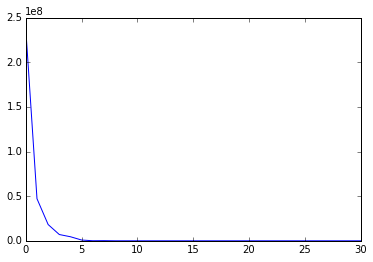

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 11 17:22:08 2016

@author: ceren
"""

import tensorflow as tf
import numpy as np
import zipfile
from matplotlib import pyplot as plt
%matplotlib inline 

# Load dataset
zip_ref = zipfile.ZipFile("data/ORL_faces.npz.zip", 'r')
zip_ref.extractall("data/")
zip_ref.close()

data = np.load('data/ORL_faces.npz')

trainX = data['trainX']
testX = data['testX']
trainY = data['trainY']
testY = data['testY']

# Parameters
n_class = np.unique(trainY).size
n_input = trainX.shape[1]
train_size = trainX.shape[0]
test_size = testX.shape[0]
M, N = 112, 92
batch_size = 32
display_step = 10
learning_rate = .01
iters = 10000
dropout = .6

# Convert labels to one-hot vectors
trainY = np.eye(n_class)[trainY]
testY = np.eye(n_class)[testY]

# tf inputs, variables
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_class])
dropout_prob = tf.placeholder(tf.float32)
weights = {
    # 3x3 conv, 1 input, 28 outputs
    'wconv1': tf.Variable(tf.random_normal([3, 3, 1, 28])),
    # 5x5 conv, 28 inputs, 32 outputs
    'wconv2': tf.Variable(tf.random_normal([5, 5, 28, 32])),
    # 7x7 conv, 32 inputs, 64 outputs
    'wconv3': tf.Variable(tf.random_normal([7, 7, 32, 64])),
    # fully connected, 7*6*64 inputs, 1024 outputs
    'wfc1': tf.Variable(tf.random_normal([7*6*64, 1024])),
    # fully connected, 1024 inputs, 1024 outputs
    'wfc2': tf.Variable(tf.random_normal([1024, 1024])),
    # 1024 inputs, 20 outputs   
    'out': tf.Variable(tf.random_normal([1024, n_class]))
}

biases = {
    'bconv1': tf.Variable(tf.random_normal([28])),
    'bconv2': tf.Variable(tf.random_normal([32])),
    'bconv3': tf.Variable(tf.random_normal([64])),
    'bfc1': tf.Variable(tf.random_normal([1024])),
    'bfc2': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_class]))
}

# Conv2d function
def conv2d(x, W, b, strides=1):
    # Conv2D with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

# Maxpool2d function
def maxpool2d(x, k=2):
    # MaxPool2D 
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

# Define CNN
def conv_net(x, weights, biases, dropout):
    
    # reshape input
    x = tf.reshape(x, shape=[-1, M, N, 1])

    # First Convolution Layer
    conv1 = conv2d(x, weights['wconv1'], biases['bconv1'])
    conv1 = maxpool2d(conv1, k=2)

    # Second Convolution Layer
    conv2 = conv2d(conv1, weights['wconv2'], biases['bconv2'], strides = 2)
    conv2 = maxpool2d(conv2, k=2)
    
    # Third Convolution Layer
    conv3 = conv2d(conv2, weights['wconv3'], biases['bconv3'])
    conv3 = maxpool2d(conv3, k=2)

    # First Fully connected layer
    fc1 = tf.reshape(conv3, [-1, weights['wfc1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wfc1']), biases['bfc1'])
    fc1 = tf.nn.relu(fc1)
    
    # Dropout regularizaiton
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Second Fully connected layer
    fc2 = tf.add(tf.matmul(fc1, weights['wfc2']), biases['bfc2'])
    fc2 = tf.nn.relu(fc2)
    
    fc2 = tf.nn.dropout(fc2, dropout)

    # Class prediction
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return out
    
def nextBatch():
    idx = np.random.choice(train_size,size=batch_size,replace=False)
    batch_x = trainX[idx, :]
    batch_y = trainY[idx, :]
    return batch_x, batch_y  
    
def visualizationofWeights(weights):

    for wname, w in weights.items():
        # Take only conv weights
        if wname.startswith('wconv'): 
            
            plt.figure(figsize=(18, 18))

            nFilter = w.shape[3]
            k = w.shape[0]

            for i in range(nFilter):
                img = w[:,:,0,i]
                img = img.reshape(k,k)
                
                plt.subplot(1,nFilter,i)
                plt.cla()
                
                plt.imshow(img)
                
                frame = plt.gca()
                frame.axes.get_xaxis().set_ticks([])
                frame.axes.get_yaxis().set_ticks([])
                
            plt.title('Filters:' + wname[1:])
            plt.savefig('filters_'+ wname[1:] + '.png')
            

        
# Construct model
pred = conv_net(x, weights, biases, dropout_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) 

# Initialize the variables
init = tf.initialize_all_variables()

losses = []

# Launch the graph
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(init)
        step = 1
        while step * batch_size < iters:
            batch_x, batch_y = nextBatch()
            # Run optimization 
            _,w = sess.run([optimizer, weights], feed_dict={x: batch_x, y: batch_y, dropout_prob:dropout} )
            
            if step % display_step == 0:
                # Calculate batch loss and accuracy
                loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, dropout_prob: 1.0 })
                print("Iteration " + str(step*batch_size) + ", Minibatch Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
                losses.append(loss)
            step += 1
        print("Optimization Finished!")
        visualizationofWeights(w)
        # Calculate accuracy for test images
        print("Testing Accuracy:", \
            sess.run(accuracy, feed_dict={x: testX, y: testY, dropout_prob: 1.0}))   
            
        
fig = plt.figure()
plt.plot(losses)
plt.show()